# Method development strategies

*Goal*
- harmonise two timeseries with *harmonisation time* ($t_0$) and *convergence time* ($t_{\text{conv}}$) such that:
    - zero-oder derivative matches
    - first-order derivative matches
- overall idea: *smooth* transition from one timeseries to another one.

*Terminology*
- `historical`: timeseries 1; timeseries presenting the observed, historical data
- `predicted_orig`: timeseries 2; originally, predicted data
- `t0`: *harmonisation time*; time point at which both timeseries should be matched
- `t_conv`: *convergence time*; time point at which the interpolated, new timeseries should again match the target timeseries

*Data format*
- a timeseries is considered to be a tuple $(x,y)$ where $x$ refers to the time axis (e.g., year) and $y$ refers to the obs/pred. value
- Question: Should we only allow this pint dataformat?

## Starting Situation

Making up some artificial data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from keras.src.utils import timeseries_dataset_from_array

# create historical data
x1 = np.linspace(-2, 4., 300)
y1 = -6*x1
historical = (x1, y1)

# create interpolated data
x2 = np.linspace(2, 6, 300)
y2 = 0.5*x2 + x2**3
original_pred = (x2, y2)

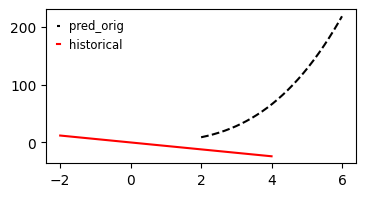

In [2]:
plt.figure(figsize=(4,2))
plt.plot(original_pred[0], original_pred[1], label="pred_orig", linestyle="--", color="black")
plt.plot(historical[0], historical[1], label="historical", color="red")
plt.legend(handlelength=0.3, fontsize="small", frameon=False)
plt.show()

## Methods for matching two functions

### Method 1:
+ focus: match *zero-order* derivative at $t_0$
+ implementation:
    + compute $\Delta(y_\text{hist}-y_\text{pred-orig})$ at $x = t_0$
    + adjust original predictions: $y_\text{pred-abs}= y_\text{pred-orig}+\Delta(y_\text{hist}-y_\text{pred-orig})$
+ comment:
    + adjusted timeseries matches with observed, historical data regading the absolute value but the sharpe change in slope might be unrealistic

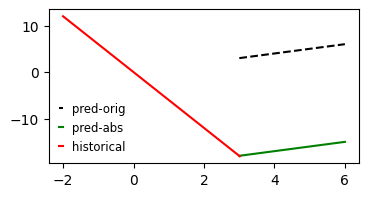

In [3]:
from gradient_aware_harmonisation.harmonise import harmonise


# harmonisation time
t0 = 3.
# run harmonisation
res = harmonise((x1,x2), (y1,x2), t0=t0)

# method 1
plt.figure(figsize=(4,2))
plt.plot(res["x2"], res["f2"], label="pred-orig", linestyle="--", color="black")
plt.plot(res["x2"], res["f2_abs"], label="pred-abs", color="green")
plt.plot(res["x1"], res["f1"], label="historical", color="red")
plt.legend(handlelength=0.3, fontsize="small", frameon=False)
plt.show()


## Method 2
+ focus: match zero- and first-order derivative
+ implementation:
    + interpolate both function using `scipy.interpolate.make_interp_spline`
    + compute and adjust for first-order derivatives
        + $dy_\text{slope} = dy_\text{pred-orig}+\Delta(dy_\text{hist}-dy_\text{pred-orig})$
    + estimate $df_\text{pred-slope}$ from $(x, dy_\text{pred-slope})$ using `scipy.interpolate.make_interp_spline`
    + compute antiderivative to obtain $f_\text{pred-slope}$
    + adjust zero-order derivative
        + $y_\text{pred-abs/slope} = y_\text{pred-slope}+\Delta(y_\text{pred-abs}-y_\text{pred-slope})$
+ comment:
    + adjust slope to shifted data instead of original predictions in order to correct for the bias in the predictions
    + approach doesn't work in this sequential ordering; would only work if we adjust for slope and absolute value simultaneously


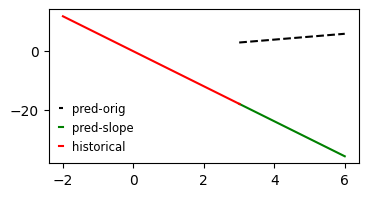

In [4]:
# method 2
plt.figure(figsize=(4,2))
plt.plot(res["x2"], res["f2"], label="pred-orig", linestyle="--", color="black")
plt.plot(res["x2"], res["f2_adj"], label="pred-slope", color="green")
plt.plot(res["x1"], res["f1"], label="historical", color="red")
plt.legend(handlelength=0.3, fontsize="small", frameon=False)
plt.show()


## Method 3
+ focus: interpolate between shifted and adjusted timeseries
+ implementation:
    + compute weighted average between shifted and shifted+sloped-adjusted function
    $$\frac{1}{2} (\gamma_i \cdot y_\text{pred-abs/slope} + 1-\gamma_i \cdot y_\text{pred-abs}) \quad \text{ for } i=1,\ldots, x_n$$
    + with weights $\gamma_i$ following a cosine-decay function
        + for $i:1$ -> $y_\text{pred-intpol}=y_\text{pred-abs/slope}$
        + for $i:x_n$ -> $y_\text{pred-intpol}=y_\text{pred-abs}$
+ comments:
    + at $t_0$, we try to control for slope and absolute value simultaneously (ensure that we have a good match and a smooth transition)
    + after $t_0$, the function aligns more and more to the **unbiased** predictions

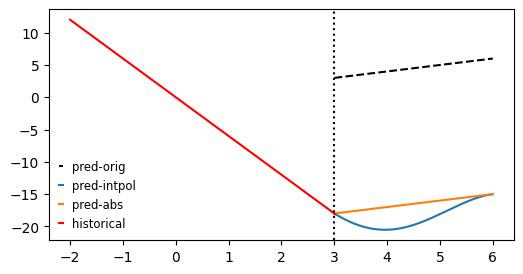

In [5]:
plt.figure(figsize=(6,3))
plt.plot(res["x2"], res["f2"], label="pred-orig", linestyle="--", color="black")
plt.plot(res["x2"], res["f2_intpol"], label="pred-intpol")
plt.plot(res["x2"], res["f2_abs"], label="pred-abs")
#plt.plot(res["x2"], res["f2_adj"], label="abs+slope")
plt.plot(res["x1"], res["f1"], label="historical", color="red")
plt.axvline(t0, color="black", linestyle="dotted")
#plt.axvline(t_converge, color="black", linestyle="dotted")
#plt.text(t0+0.2, -110, "$t_0$" )
#plt.text(t_converge+0.2, -110, r"$t_\text{conv}$" )
plt.legend(handlelength=0.3, fontsize="small", frameon=False, loc="lower left")
plt.show()


### Method 3 with convergence time $t_\text{conv}$
+ it is reasonably that we want `pred-intpol` to converge to the unbiased predictions `pred-abs` at a predefined time point $t_\text{conv}$ (i.e., convergence time)
+ implementation:
    + let the cosine-decay of the weight in the weighted average converge already at $t=t_\text{conv}$

In [6]:
# convergence time
t_conv = 5.
# run harmonisation
res = harmonise((x1,x2), (y1,x2), t0=t0, t_converge=t_conv)

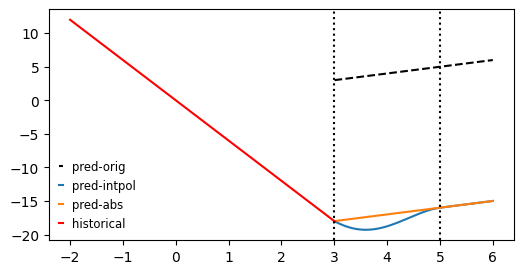

In [8]:
plt.figure(figsize=(6,3))
plt.plot(res["x2"], res["f2"], label="pred-orig", linestyle="--", color="black")
plt.plot(res["x2"], res["f2_intpol"], label="pred-intpol")
plt.plot(res["x2"], res["f2_abs"], label="pred-abs")
plt.plot(res["x1"], res["f1"], label="historical", color="red")
plt.axvline(t0, color="black", linestyle="dotted")
plt.axvline(t_conv, color="black", linestyle="dotted")
plt.legend(handlelength=0.3, fontsize="small", frameon=False, loc="lower left")
plt.show()


## Questions:
- is it a valid assumption that we converge the `pred-intpol` to the unbiased predictions (i.e., predictions shifted towards historical data)?
    - I would assume that a biased prediction would also interpolate this bias into the future; therefore I think it is reasonable to use the unbiased predictions as convergence target.
- current focus is on matching two function at a time point $t_0$; How about matching functions over a sequence of overlapping time points?
- which input format should we support?
    - data in list format
    - data that have units with pint
- when the slope value or the absolute value does not match exactly: How much error do we tolerate?
## Potential additional features:
- using different decay options for the weights; current choice: `cosine-decay` (from tensorflow learning-rate schedules)
- using different interpolation functions; current choice: `scipy.interpolate.make_interp_spline`